In [1]:
import os #directory
import librosa #handling audio
import IPython.display as ipd #to listen audio
import matplotlib.pyplot as plt #graph
import numpy as np #array
from scipy.io import wavfile #audio wav file

In [4]:
trainDir = 'train/'
samples, sample_rate = librosa.load(trainDir+'bed/00176480_nohash_0.wav', sr = 16000)
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [5]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [6]:
labels=os.listdir(trainDir)
labels

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four']

In [7]:
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(trainDir + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

In [8]:
labels=["bed", "bird", "cat", "dog", "down", "eight", "five", "four"]

(array([2.0000e+00, 6.0000e+00, 4.2000e+01, 2.6000e+01, 9.0000e+01,
        1.5600e+02, 2.3300e+02, 1.9800e+02, 3.4800e+02, 1.3522e+04]),
 array([0.384 , 0.4456, 0.5072, 0.5688, 0.6304, 0.692 , 0.7536, 0.8152,
        0.8768, 0.9384, 1.    ]),
 <BarContainer object of 10 artists>)

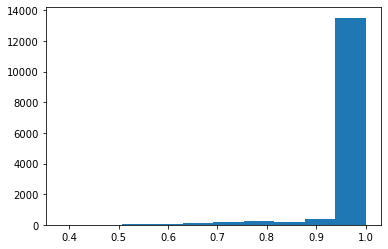

In [9]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(trainDir + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(trainDir + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [10]:
trainDir = 'train/'
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(trainDir + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(trainDir + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

bed
bird
cat
dog
down
eight
five
four


In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
print(classes)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four']


In [12]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.
c:\users\shanm\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\shanm\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\shanm\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [13]:
all_wave = np.array(all_wave).reshape(-1,8000,1)


In [14]:

from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [15]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_____________________

In [16]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('voiceRecModel.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
print(x_tr.shape, x_val.shape, y_tr.shape, y_val.shape)

(10448, 8000, 1) (2613, 8000, 1) (10448, 8) (2613, 8)


In [ ]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))


Train on 10448 samples, validate on 2613 samples
Epoch 1/100
10448/10448 [==============================] - 96s 9ms/step - loss: 0.7582 - acc: 0.7376 - val_loss: 0.6486 - val_acc: 0.7865

Epoch 00001: val_acc improved from -inf to 0.78645, saving model to voiceRecModel.hdf5
Epoch 2/100
10448/10448 [==============================] - 97s 9ms/step - loss: 0.6369 - acc: 0.7841 - val_loss: 0.5768 - val_acc: 0.8052

Epoch 00002: val_acc improved from 0.78645 to 0.80520, saving model to voiceRecModel.hdf5
Epoch 3/100
10448/10448 [==============================] - 84s 8ms/step - loss: 0.5941 - acc: 0.8005 - val_loss: 0.5060 - val_acc: 0.8351

Epoch 00003: val_acc improved from 0.80520 to 0.83506, saving model to voiceRecModel.hdf5
Epoch 4/100
10448/10448 [==============================] - 90s 9ms/step - loss: 0.5299 - acc: 0.8228 - val_loss: 0.4827 - val_acc: 0.8366

Epoch 00004: val_acc improved from 0.83506 to 0.83659, saving model to voiceRecModel.hdf5
Epoch 5/100
10448/10448 [=============

In [50]:
model.save("voiceRecModel.hdf5")

# Model Test

In [25]:
from keras.models import load_model

model = load_model("voiceRecModel.hdf5")

ValueError: Unknown layer: Functional

In [19]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)



Audio: five


In [21]:
print("Text:",predict(samples))

Text: bird
